In [2]:
# Necessary imports
import os
import scipy.io as sio
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ssqueezepy import ssq_cwt, cwt, Wavelet
import pywt

import random
import torch

from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

def seed_reproducer(seed=2333):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = True

seed_reproducer(2333)

In [7]:
# Show ECG signal
def show_ecg(ecg_data, fs):
    ecg_data = ecg_data.squeeze()
    time = np.arange(len(ecg_data))

    ecg_data = ecg_data[1000: 2000]
    time = time[1000: 2000]

    plt.figure(figsize=(12, 4))
    plt.plot(time, ecg_data, label="ECG Signal", color="blue", linewidth=1.5)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (mV)")
    plt.title("ECG Signal Visualization")
    plt.legend()
    plt.grid()
    plt.show()

# Show ECG signal with masks
# 0: None, 1: P, 2: QRS, 3: T
# P: Green; QRS: Red; T: Oriange

def show_ecg_with_masks(ecg_data, ecg_mask, fs):
    color_map = {0: "blue", 1: "green", 2: "red", 3: "orange"}
    name_map  = {0: "None", 1: "P", 2: "QRS", 3: "T"}

    ecg_data = ecg_data.squeeze()
    ecg_mask = ecg_mask.squeeze()
    time = np.arange(len(ecg_data))

    ecg_data = ecg_data[1000: 2000]
    ecg_mask = ecg_mask[1000: 2000]
    time = time[1000: 2000]

    plt.figure(figsize=(12, 4))

    added_labels = set()

    for label, color in color_map.items():
        mask = ecg_mask == label
        if np.any(mask):
            indices = np.where(mask)[0]
            split_indices = np.split(indices, np.where(np.diff(indices) > 1)[0] + 1)

            for segment in split_indices:
                if label not in added_labels:
                    plt.plot(time[segment], ecg_data[segment], color=color, linewidth=1.5, label="{}".format(name_map[label]))
                    added_labels.add(label)
                else:
                    plt.plot(time[segment], ecg_data[segment], color=color, linewidth=1.5)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (mV)")
    plt.title("ECG Signal Visualization")
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# Change the label to 0-based
# 0: None, 1: P, 2: QRS, 3: T

def change_label_to_mask(ecg_data, ecg_label):
    temp_ecg_label = np.zeros_like(ecg_data)
    for i in range(ecg_label.shape[0]):
        start_idx, end_idx = ecg_label[i][0][0][0], ecg_label[i][0][0][1]
        wave_type = ecg_label[i][1][0]

        if wave_type == 'P':
            temp_ecg_label[start_idx: end_idx, :] = 1
        elif wave_type == 'QRS':
            temp_ecg_label[start_idx: end_idx, :] = 2
        elif wave_type == 'T':
            temp_ecg_label[start_idx: end_idx, :] = 3
        else:
            pass
    return temp_ecg_label

In [ ]:
# Design Elliptic Bandpass Filter
# 0.5 - 40 Hz

# design elliptic bandpass filter
def ellip_bandpass(lowcut, highcut, stop_low, stop_high, fs):
    nyquist = 0.5 * fs  # nyquist frequency
    wp = [lowcut / nyquist, highcut / nyquist]  # passband
    ws = [stop_low / nyquist, stop_high / nyquist]  # stopband
    gpass = 0.5  # passband ripple (dB)
    gstop = 40   # stopband attenuation (dB)

    # Calculate the order and critical frequency
    N, Wn = signal.ellipord(wp, ws, gpass, gstop)
    
    # Design the filter
    b, a = signal.ellip(N, gpass, gstop, Wn, btype='band')
    return b, a

# Apply Elliptic Bandpass Filter
def apply_bandpass_filter_ellip(data, lowcut, highcut, stop_low, stop_high, fs):
    b, a = ellip_bandpass(lowcut, highcut, stop_low, stop_high, fs)
    filtered_data = signal.filtfilt(b, a, data)  # use filtfilt to apply the filter
    return filtered_data

# Design Butterworth Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# Apply Butterworth Bandpass Filter
def apply_bandpass_filter_butterworth(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = signal.filtfilt(b, a, data)  # use filtfilt to apply the filter
    return filtered_data

In [ ]:
# Load mat
# each mat file contains 'Fs', 'ecgSignal', 'signalRegionLabels'
# 'Fs' = 250

# demo data
data = sio.loadmat('./data/QTDataset_python/ecg63.mat', struct_as_record=False)

print(data.keys())
Fs = data['Fs']
ecgSignal = data['ecgSignal']
signalRegionLabels = data['signalRegionLabels']

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ecgSignal', 'signalRegionLabels'])


In [ ]:
all_files = os.listdir('./data/QTDataset_python/')
all_files = sorted([f for f in all_files if f.endswith('.mat')])

for f in all_files:
    data = sio.loadmat('./data/QTDataset_python/' + f, struct_as_record=False)
    Fs = data['Fs']
    if Fs != 250:
        print(f, Fs)
    ecgSignal = data['ecgSignal']
    print(f + ': ', ecgSignal.shape)

ecg1.mat:  (225000, 1)
ecg10.mat:  (225000, 1)
ecg100.mat:  (224993, 1)
ecg101.mat:  (224993, 1)
ecg102.mat:  (224993, 1)
ecg103.mat:  (224993, 1)
ecg104.mat:  (224993, 1)
ecg105.mat:  (224993, 1)
ecg106.mat:  (224993, 1)
ecg107.mat:  (224993, 1)
ecg108.mat:  (224993, 1)
ecg109.mat:  (224993, 1)
ecg11.mat:  (225000, 1)
ecg110.mat:  (224993, 1)
ecg111.mat:  (224993, 1)
ecg112.mat:  (224993, 1)
ecg113.mat:  (224993, 1)
ecg114.mat:  (224993, 1)
ecg115.mat:  (224993, 1)
ecg116.mat:  (224993, 1)
ecg117.mat:  (224993, 1)
ecg118.mat:  (224993, 1)
ecg119.mat:  (224999, 1)
ecg12.mat:  (225000, 1)
ecg120.mat:  (224999, 1)
ecg121.mat:  (224999, 1)
ecg122.mat:  (224999, 1)
ecg123.mat:  (224999, 1)
ecg124.mat:  (224999, 1)
ecg125.mat:  (224999, 1)
ecg126.mat:  (224999, 1)
ecg127.mat:  (224999, 1)
ecg128.mat:  (224999, 1)
ecg129.mat:  (224999, 1)
ecg13.mat:  (225000, 1)
ecg130.mat:  (224999, 1)
ecg131.mat:  (224999, 1)
ecg132.mat:  (224999, 1)
ecg133.mat:  (224999, 1)
ecg134.mat:  (224999, 1)
ecg135

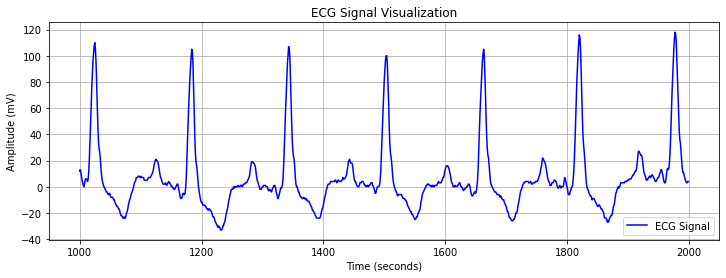

In [25]:
# Plot ECG signal
show_ecg(ecgSignal, Fs)

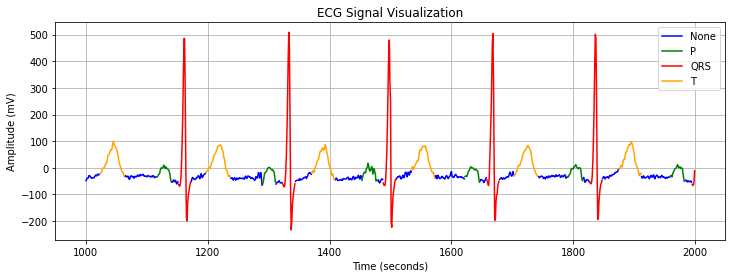

In [38]:
# Plot ECG signal with masks
ecg_mask = change_label_to_mask(ecgSignal, signalRegionLabels)
show_ecg_with_masks(ecgSignal, ecg_mask, Fs)

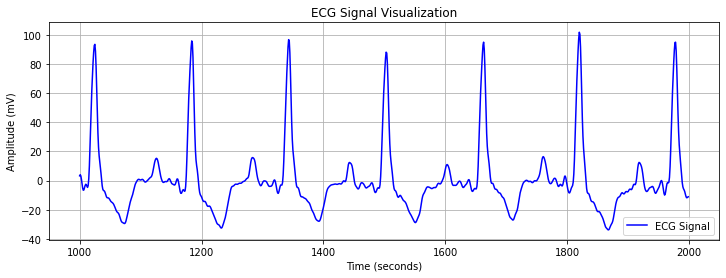

In [ ]:
# Plot ECG signal after bandpass filter
lowcut = 0.5  # left cut-off frequency
highcut = 40  # right cut-off frequency
stop_low = 0.4  # left stopband frequency
stop_high = 45  # right stopband frequency

filtered_ecg = apply_bandpass_filter_ellip(ecgSignal.squeeze(), lowcut, highcut, stop_low, stop_high, Fs)
show_ecg(filtered_ecg, Fs)

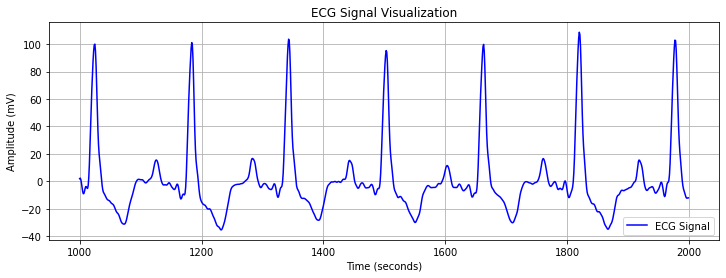

In [ ]:
# Plot ECG signal after bandpass filter
lowcut = 0.5  # left passband frequency
highcut = 40  # right passband frequency

filtered_ecg = apply_bandpass_filter_butterworth(ecgSignal.squeeze(), lowcut, highcut, Fs)
show_ecg(filtered_ecg, Fs)

(224993,)


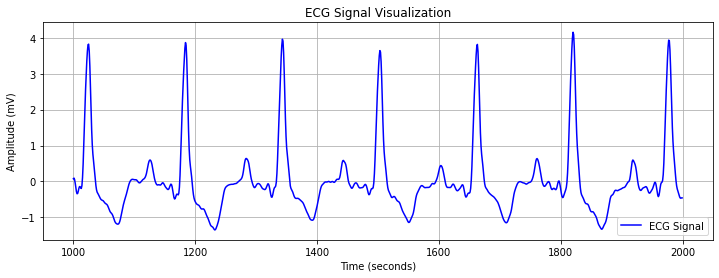

In [30]:
# Plot z-score norm ECG signal after bandpass filter
print(filtered_ecg.shape)

mean = np.mean(filtered_ecg)
std  = np.std(filtered_ecg)
filtered_ecg_norm = (filtered_ecg - mean) / std

show_ecg(filtered_ecg_norm, Fs)

(1000,)
(1000,)
(40, 1000)
(40,)
[ 0.15802596  0.18775199  0.16865051  0.10881813  0.13975174  0.15767725
  0.20045927  0.25124632  0.36712801  0.52795137  0.95869018  1.82348005
  2.84945747  3.21350541  2.18891307  2.59541891 10.83546171 21.70535823
 33.40197531 43.87891444 50.75940443 54.50566438 55.10435631 57.60499948
 63.34992149 70.9400157  63.46287537 54.8860027  60.45982308 57.37110945
 34.21675738 12.73805101 10.07310795 14.08104964 14.70964305 12.36834418
  9.35567823  3.22554791  1.58692511]


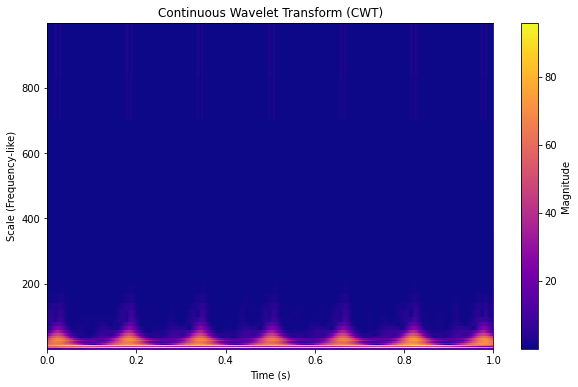

In [ ]:
# Continuous Wavelet Transform (CWT)
# wavelet = Wavelet('morlet') 
# filtered_ecg = ecgSignal.squeeze()
ecg_clip = filtered_ecg[1000: 2000]
print(ecg_clip.shape)
# ecg_clip = ecg_clip.reshape(-1, 1)
print(ecg_clip.shape)

time = np.linspace(0, 1, ecg_clip.shape[0])
sampling_period = np.diff(time).mean()

widths = np.geomspace(1, 1024, num=40)
cwtmatr, freqs = pywt.cwt(ecg_clip, widths, 'cmor1.5-1.0', sampling_period=sampling_period)  # CWT 计算
print(cwtmatr.shape)

cwtmatr = np.abs(cwtmatr[:-1, :-1])
print(freqs.shape)

print(cwtmatr[:, 0])

# Plot FSST
plt.figure(figsize=(10, 6))
plt.pcolormesh(time, freqs, cwtmatr, cmap="plasma")
plt.colorbar(label="Magnitude")
plt.xlabel("Time (s)")
plt.ylabel("Scale (Frequency-like)")
plt.title("Continuous Wavelet Transform (CWT)")
plt.show()

(1000,)
(1000,)
()


/tmp/ipykernel_1479420/332068158.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(time, ssq_freqs, np.abs(Tx))


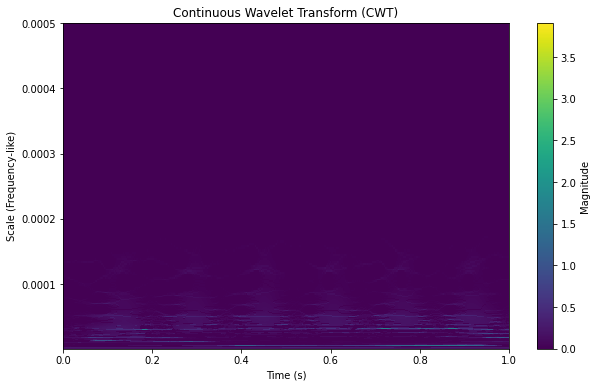

In [ ]:
# Calculate SSQ-CWT
ecg_clip = filtered_ecg[2000:3000]
print(ecg_clip.shape)
# ecg_clip = ecg_clip.reshape(-1, 1)
print(ecg_clip.shape)

time = np.linspace(0, 1, 1000)
sampling_period = np.diff(time).mean()

print(sampling_period.shape)

# Morlet
wavelet = Wavelet('morlet')

Tx, Wx, ssq_freqs, *_ = ssq_cwt(ecg_clip, wavelet, fs=sampling_period)

# Plot FSST
plt.figure(figsize=(10, 6))
plt.pcolormesh(time, ssq_freqs, np.abs(Tx))
plt.colorbar(label="Magnitude")
plt.xlabel("Time (s)")
plt.ylabel("Scale (Frequency-like)")
plt.title("Continuous Wavelet Transform (CWT)")
plt.show()

In [3]:
all_files = os.listdir('./data/QTDataset_python/')
all_files = sorted([f for f in all_files if f.endswith('.mat')])

ratio = 0.7

random.shuffle(all_files)

train_files = all_files[:int(ratio * len(all_files))]
test_files = all_files[int(ratio * len(all_files)):]
print(len(train_files), len(test_files))
print(train_files)
print(test_files)

147 63
['ecg104.mat', 'ecg180.mat', 'ecg178.mat', 'ecg134.mat', 'ecg84.mat', 'ecg161.mat', 'ecg76.mat', 'ecg155.mat', 'ecg138.mat', 'ecg164.mat', 'ecg16.mat', 'ecg34.mat', 'ecg99.mat', 'ecg62.mat', 'ecg163.mat', 'ecg126.mat', 'ecg118.mat', 'ecg147.mat', 'ecg114.mat', 'ecg51.mat', 'ecg149.mat', 'ecg67.mat', 'ecg101.mat', 'ecg187.mat', 'ecg12.mat', 'ecg74.mat', 'ecg209.mat', 'ecg194.mat', 'ecg192.mat', 'ecg95.mat', 'ecg150.mat', 'ecg86.mat', 'ecg195.mat', 'ecg69.mat', 'ecg183.mat', 'ecg21.mat', 'ecg88.mat', 'ecg117.mat', 'ecg8.mat', 'ecg197.mat', 'ecg92.mat', 'ecg73.mat', 'ecg185.mat', 'ecg173.mat', 'ecg129.mat', 'ecg146.mat', 'ecg81.mat', 'ecg175.mat', 'ecg136.mat', 'ecg191.mat', 'ecg24.mat', 'ecg210.mat', 'ecg159.mat', 'ecg148.mat', 'ecg130.mat', 'ecg123.mat', 'ecg120.mat', 'ecg59.mat', 'ecg190.mat', 'ecg53.mat', 'ecg186.mat', 'ecg77.mat', 'ecg45.mat', 'ecg13.mat', 'ecg38.mat', 'ecg9.mat', 'ecg5.mat', 'ecg144.mat', 'ecg48.mat', 'ecg153.mat', 'ecg35.mat', 'ecg165.mat', 'ecg112.mat', 'ec

In [ ]:
# Define ECG Dataset

def zscore_norm(data):
    mean = np.mean(data)
    std  = np.std(data)
    return (data - mean) / std

def minmax_norm(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

class ECGDataset(Dataset):
    def __init__(self, files, time_steps=5000):
        self.data_dir = '/home/jh21/Project/ECG_Seg/data/QTDataset_python'
        self.files = files
        
        ecg_data_all = []
        ecg_mask_all = []

        for file in self.files:
            data = sio.loadmat(os.path.join(self.data_dir, file), struct_as_record=False)
            ecg_data_subject = data['ecgSignal']
            ecg_label = data['signalRegionLabels']
            ecg_mask_subject = change_label_to_mask(ecg_data_subject, ecg_label)

            # denosing filter
            ecg_data_subject = apply_bandpass_filter_butterworth(ecg_data_subject.squeeze(), 0.5, 40, 250)

            # Z-Score
            ecg_data_subject = zscore_norm(ecg_data_subject)

            subject_ecg_length = ecg_data_subject.shape[0]

            for i in range(subject_ecg_length // time_steps):
                ecg_data_all.append(np.array(ecg_data_subject[i * time_steps: (i+1) * time_steps]).reshape(1, time_steps, 1))
                ecg_mask_all.append(np.array(ecg_mask_subject[i * time_steps: (i+1) * time_steps]).reshape(1, time_steps))

        self.ecg_data_all = np.vstack(ecg_data_all)
        self.ecg_mask_all = np.vstack(ecg_mask_all)

        print(self.ecg_data_all.shape, self.ecg_mask_all.shape)

    def __len__(self):
        return self.ecg_data_all.shape[0]

    def __getitem__(self, index):
        ecg_data = self.ecg_data_all[index]
        ecg_mask = self.ecg_mask_all[index]

        return torch.from_numpy(ecg_data).to(dtype=torch.float), torch.from_numpy(ecg_mask).to(dtype=torch.long)


In [86]:
time_steps = 2500
train_ecg_dataset = ECGDataset(train_files, time_steps=time_steps)
test_ecg_dataset = ECGDataset(test_files, time_steps=time_steps)

(13159, 2500, 1) (13159, 2500)
(5637, 2500, 1) (5637, 2500)


In [ ]:
train_loader = DataLoader(train_ecg_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(test_ecg_dataset,  batch_size=64, shuffle=True, num_workers=0)

for batch_idx, (signals, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"  ECG Signal Shape: {signals.shape}")  # (batch_size, time_steps, features)
    print(f"  Label Shape: {labels.shape}")  # (batch_size, time_steps)
    break

for batch_idx, (signals, labels) in enumerate(valid_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"  ECG Signal Shape: {signals.shape}")  # (batch_size, time_steps, features)
    print(f"  Label Shape: {labels.shape}")  # (batch_size, time_steps)
    break

Batch 1:
  ECG Signal Shape: torch.Size([64, 2500, 1])
  Label Shape: torch.Size([64, 2500])
Batch 1:
  ECG Signal Shape: torch.Size([64, 2500, 1])
  Label Shape: torch.Size([64, 2500])


In [ ]:
features = 1
num_classes = 4
hidden_size = 128
num_layers = 2

class ECG_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(ECG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, time_steps, hidden_size)
        out = self.fc(lstm_out)  # (batch, time_steps, num_classes)
        return out
    
model = ECG_LSTM(input_size=features, hidden_size=hidden_size, num_classes=num_classes, num_layers=num_layers)

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [90]:
num_epochs = 20
model = model.cuda()
model.train()

for epoch in range(num_epochs):
    for batch_idx, (signals, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        ecg_data, ecg_mask = signals.cuda(), labels.cuda().long()

        outputs = model(ecg_data)  # (64, 1000, 4)
        loss = criterion(outputs.view(-1, num_classes), ecg_mask.view(-1))  # (64000, 4) vs (64000,)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/20, Loss: 0.5897035002708435
Epoch 2/20, Loss: 0.49382415413856506
Epoch 3/20, Loss: 0.44815507531166077
Epoch 4/20, Loss: 0.4478786885738373
Epoch 5/20, Loss: 0.41598302125930786
Epoch 6/20, Loss: 0.3068370521068573
Epoch 7/20, Loss: 0.39825764298439026
Epoch 8/20, Loss: 0.3125001788139343
Epoch 9/20, Loss: 0.3274756669998169
Epoch 10/20, Loss: 0.276089072227478
Epoch 11/20, Loss: 0.2830581068992615
Epoch 12/20, Loss: 0.31486499309539795
Epoch 13/20, Loss: 0.252150297164917
Epoch 14/20, Loss: 0.24726077914237976
Epoch 15/20, Loss: 0.24320867657661438
Epoch 16/20, Loss: 0.2579503357410431
Epoch 17/20, Loss: 0.34157103300094604
Epoch 18/20, Loss: 0.28762874007225037
Epoch 19/20, Loss: 0.2806995213031769
Epoch 20/20, Loss: 0.2986212968826294


In [ ]:
pred_mask_all = []
true_mask_all = []

for batch_idx, (signals, labels) in enumerate(valid_loader):
    ecg_data, ecg_mask = signals.cuda(), labels.cuda()
    with torch.no_grad():
        outputs = model(ecg_data)  # (64, 1000, 4)
    # loss = criterion(outputs.view(-1, num_classes), ecg_mask.view(-1))  # (64000, 4) vs (64000,)
    # print(f"Validation Loss: {loss.item()}")
    pred_mask = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
    pred_mask_all.append(pred_mask.cpu().numpy())
    true_mask_all.append(ecg_mask.cpu().numpy())

pred_mask_all = np.vstack(pred_mask_all).reshape(-1)
true_mask_all = np.vstack(true_mask_all).reshape(-1)

print(pred_mask_all.shape, true_mask_all.shape)

(14092500,) (14092500,)


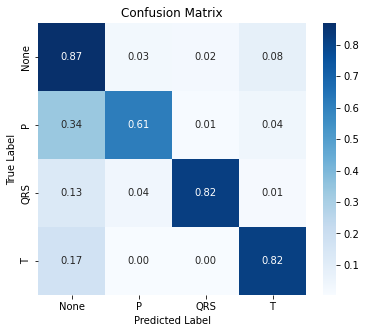

In [ ]:
# Calculate Confusion Matrix
cm = confusion_matrix(true_mask_all, pred_mask_all)

cm_prob = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_prob, annot=True, fmt=".2f", cmap="Blues", xticklabels=['None','P','QRS','T'], yticklabels=['None','P','QRS','T'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Visualize ECG Signal with Masks
for batch_idx, (signals, labels) in enumerate(valid_loader):
    ecg_data, ecg_mask = signals.cuda(), labels.cuda().long()
    with torch.no_grad():
        outputs = model(ecg_data)  # (64, 1000, 4)
    # loss = criterion(outputs.view(-1, num_classes), ecg_mask.view(-1))  # (64000, 4) vs (64000,)
    # print(f"Validation Loss: {loss.item()}")
    pred_mask = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
    break

ecg_data  = ecg_data.cpu().numpy().squeeze()[25]
ecg_mask  = ecg_mask.cpu().numpy().squeeze()[25]
pred_mask = pred_mask.cpu().numpy().squeeze()[25]

print(ecg_data.shape, ecg_mask.shape, pred_mask.shape)

(2500,) (2500,) (2500,)


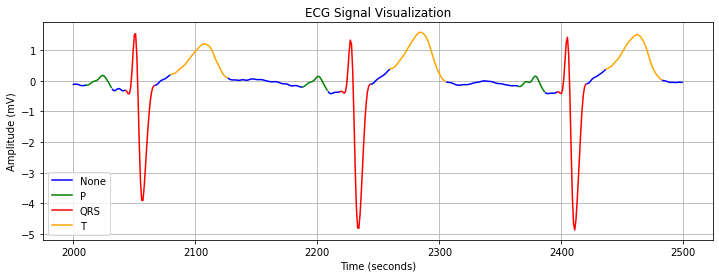

In [120]:
show_ecg_with_masks(ecg_data, ecg_mask, 250)

In [ ]:
print(ecg_data_1.shape, ecg_data_2.shape, ecg_data_3.shape)

(2500,) (2500,) (2500,)


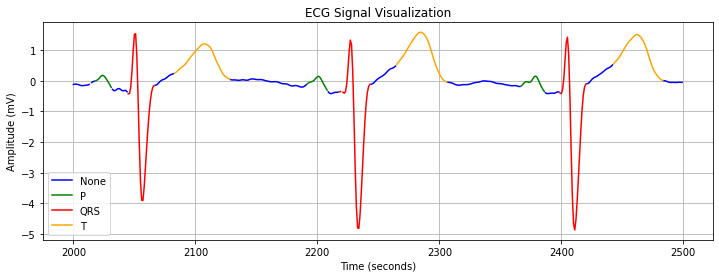

In [121]:
show_ecg_with_masks(ecg_data, pred_mask, 250)

In [19]:
# Load WFDBRecords_01_010 mat
# https://physionet.org/content/ecg-arrhythmia/1.0.0/WFDBRecords/01/010/#files-panel

Fs_original = 500
Fs_new = 250
num_leads = 12

data = sio.loadmat('./data/WFDBRecords_01_010/JS00001.mat', struct_as_record=False)
ecg_data_12leads = data['val']
print(ecg_data_12leads.shape)

new_num_samples = int(ecg_data_12leads.shape[-1] * Fs_new / Fs_original)

ecg_data_resampled = []
for i in range(num_leads):
    temp_data = signal.resample(ecg_data_12leads[i], new_num_samples)
    ecg_data_resampled.append(temp_data.reshape(1, -1))
ecg_data_resampled = np.vstack(ecg_data_resampled)
print(ecg_data_resampled.shape)

# useful leads
ecg_data_1 = ecg_data_resampled[7]
ecg_data_2 = ecg_data_resampled[8]
ecg_data_3 = ecg_data_resampled[9]

(12, 5000)
(12, 2500)


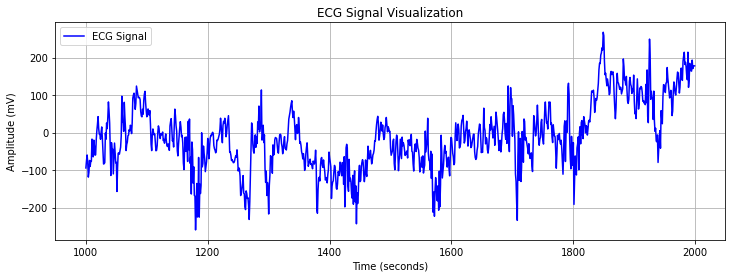

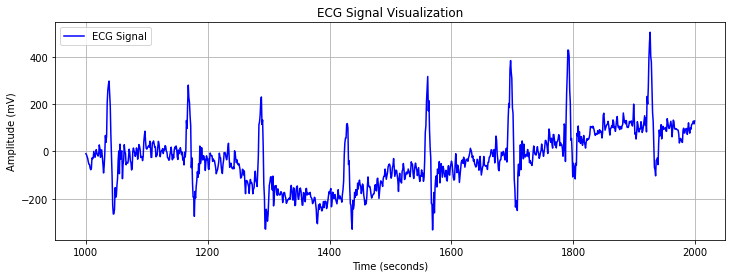

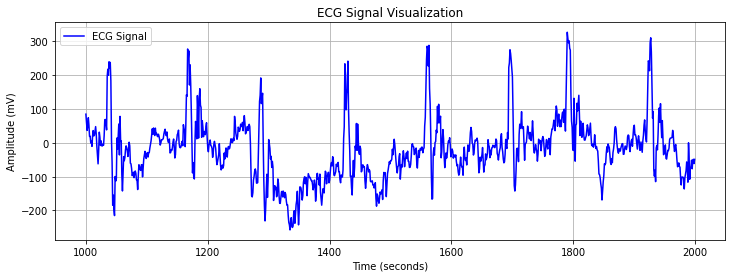

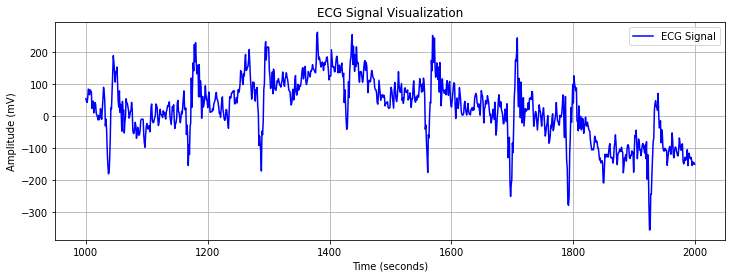

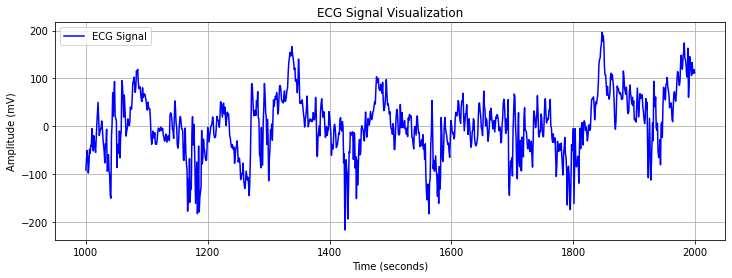

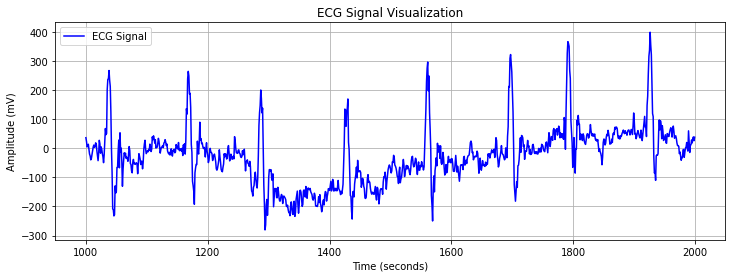

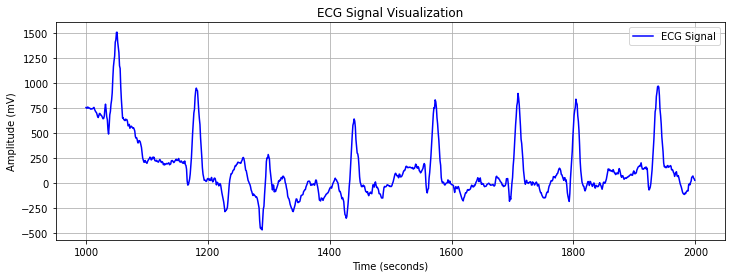

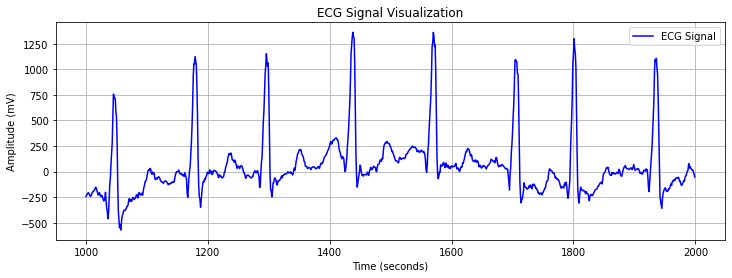

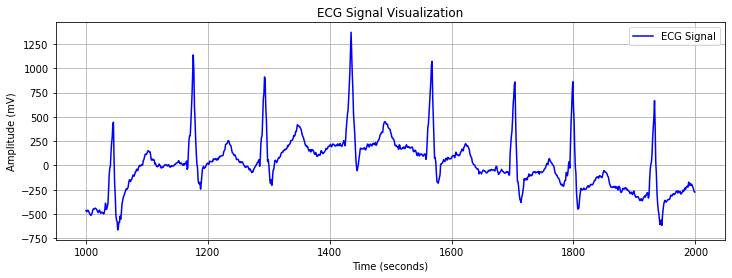

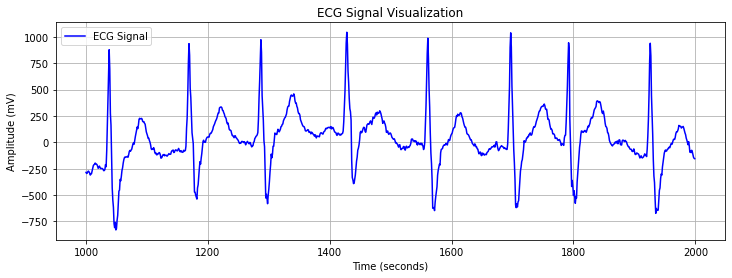

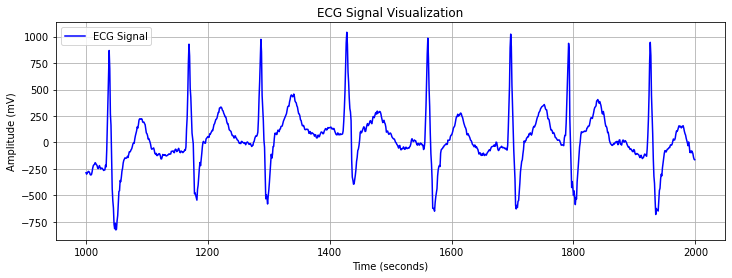

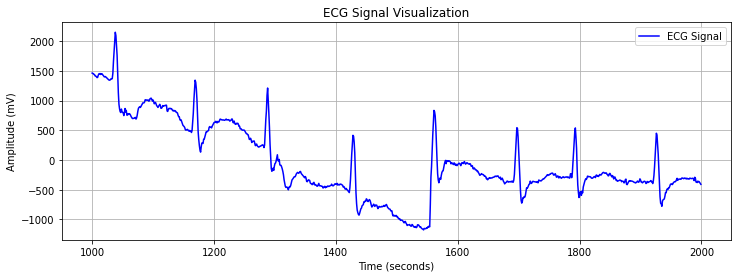

In [124]:
# Plot 12 leads ECG signal
for i in range(num_leads):
    show_ecg(ecg_data_resampled[i], Fs_new)

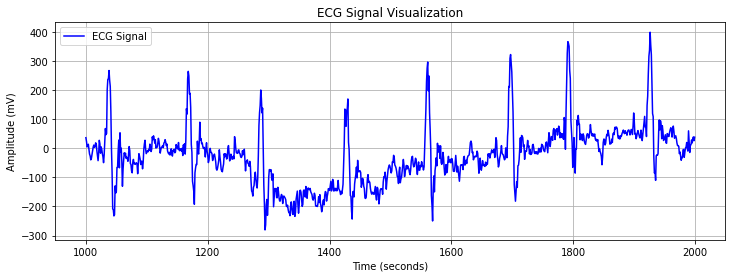

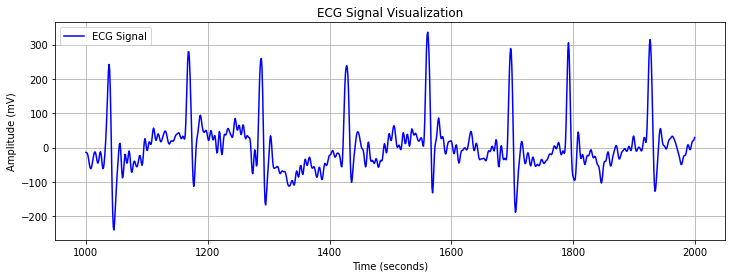

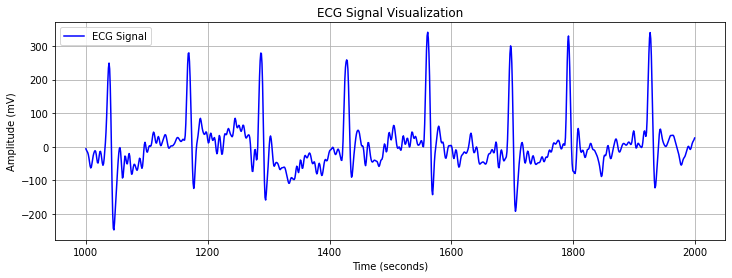

In [21]:
temp_ecg_data = ecg_data_resampled[5]
show_ecg(temp_ecg_data, 250)
temp_filtered_ecg = apply_bandpass_filter_ellip(temp_ecg_data.squeeze(), 0.5, 40, 0.4, 45, 250)
show_ecg(temp_filtered_ecg, 250)
temp_filtered_ecg = apply_bandpass_filter_butterworth(temp_ecg_data.squeeze(), 0.5, 40, 250)
show_ecg(temp_filtered_ecg, 250)

In [125]:
print(ecg_data_1.shape, ecg_data_2.shape, ecg_data_3.shape)

(2500,) (2500,) (2500,)


In [126]:
ecg_data_1_norm = apply_bandpass_filter_butterworth(ecg_data_1, 0.5, 40, 250)
ecg_data_2_norm = apply_bandpass_filter_butterworth(ecg_data_2, 0.5, 40, 250)
ecg_data_3_norm = apply_bandpass_filter_butterworth(ecg_data_3, 0.5, 40, 250)

ecg_data_1_norm = zscore_norm(ecg_data_1_norm)
ecg_data_2_norm = zscore_norm(ecg_data_2_norm)
ecg_data_3_norm = zscore_norm(ecg_data_3_norm)

print(ecg_data_1_norm.shape, ecg_data_2_norm.shape, ecg_data_3_norm.shape)

(2500,) (2500,) (2500,)


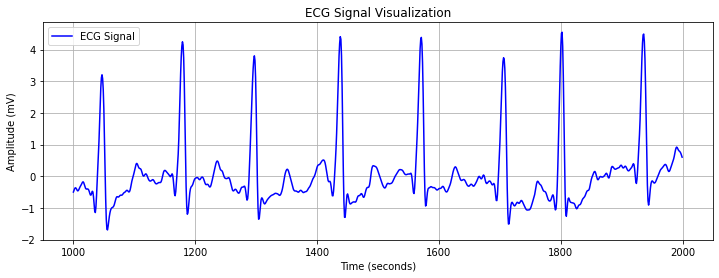

In [127]:
show_ecg(ecg_data_1_norm, Fs_new)

(2500,) (2500,)


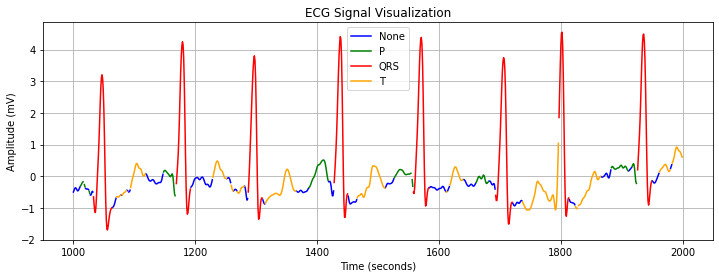

In [130]:
ecg_data = ecg_data_1_norm

ecg_data = torch.from_numpy(ecg_data).to(dtype=torch.float).cuda().reshape(1, -1, 1)
with torch.no_grad():
    outputs = model(ecg_data)  # (64, 1000, 4)
pred_mask = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)

ecg_data  = ecg_data.cpu().numpy().squeeze()
pred_mask = pred_mask.cpu().numpy().squeeze()

print(ecg_data.shape, pred_mask.shape)
show_ecg_with_masks(ecg_data, pred_mask, 250)

(2500,) (2500,)


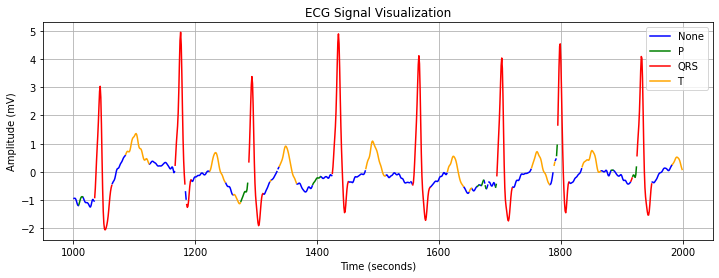

In [131]:
ecg_data = ecg_data_2_norm

ecg_data = torch.from_numpy(ecg_data).to(dtype=torch.float).cuda().reshape(1, -1, 1)
with torch.no_grad():
    outputs = model(ecg_data)  # (64, 1000, 4)
pred_mask = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)

ecg_data  = ecg_data.cpu().numpy().squeeze()
pred_mask = pred_mask.cpu().numpy().squeeze()

print(ecg_data.shape, pred_mask.shape)
show_ecg_with_masks(ecg_data, pred_mask, 250)

(2500,) (2500,)


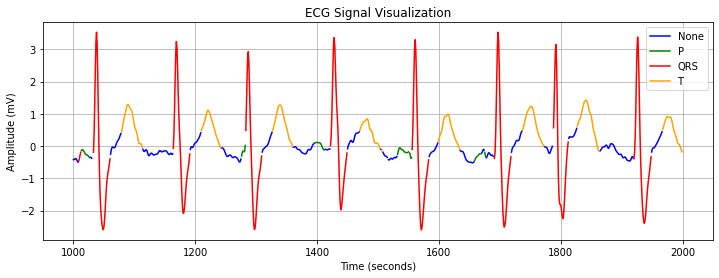

In [132]:
ecg_data = ecg_data_3_norm

ecg_data = torch.from_numpy(ecg_data).to(dtype=torch.float).cuda().reshape(1, -1, 1)
with torch.no_grad():
    outputs = model(ecg_data)  # (64, 1000, 4)
pred_mask = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)

ecg_data  = ecg_data.cpu().numpy().squeeze()
pred_mask = pred_mask.cpu().numpy().squeeze()

print(ecg_data.shape, pred_mask.shape)
show_ecg_with_masks(ecg_data, pred_mask, 250)

In [ ]:
# Let's try wavelet transform

def zscore_norm(data):
    mean = np.mean(data)
    std  = np.std(data)
    return (data - mean) / std

def minmax_norm(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

class ECGDataset(Dataset):
    def __init__(self, files, time_steps=5000, num_of_wavelets=40):
        self.data_dir = '/home/jh21/Project/ECG_Seg/data/QTDataset_python'
        self.files = files
        
        ecg_data_all = []
        ecg_mask_all = []

        for idx, file in enumerate(self.files):
            data = sio.loadmat(os.path.join(self.data_dir, file), struct_as_record=False)
            ecg_data_subject = data['ecgSignal']
            ecg_label = data['signalRegionLabels']
            ecg_mask_subject = change_label_to_mask(ecg_data_subject, ecg_label)

            # denoising filter
            ecg_data_subject = apply_bandpass_filter_butterworth(ecg_data_subject.squeeze(), 0.5, 40, 250)

            # Z-Score
            ecg_data_subject = zscore_norm(ecg_data_subject)

            # Wavelet Transform
            time = np.linspace(0, 1, ecg_data_subject.shape[0])
            sampling_period = np.diff(time).mean()
            widths = np.geomspace(1, 1024, num=num_of_wavelets)
            cwtmatr, _ = pywt.cwt(ecg_data_subject, widths, 'cmor1.5-1.0', sampling_period=sampling_period)

            subject_ecg_length = ecg_data_subject.shape[0]

            for i in range(subject_ecg_length // time_steps):
                ecg_data_all.append(np.array(cwtmatr[:, i * time_steps: (i+1) * time_steps]).swapaxes(0, 1).reshape(1, time_steps, num_of_wavelets))
                ecg_mask_all.append(np.array(ecg_mask_subject[i * time_steps: (i+1) * time_steps]).reshape(1, time_steps))

            print("{} finished".format(file))

            # if idx == 40:
            #     break

        self.ecg_data_all = np.vstack(ecg_data_all)
        self.ecg_mask_all = np.vstack(ecg_mask_all)

        print(self.ecg_data_all.shape, self.ecg_mask_all.shape)

    def __len__(self):
        return self.ecg_data_all.shape[0]

    def __getitem__(self, index):
        ecg_data = self.ecg_data_all[index]
        ecg_mask = self.ecg_mask_all[index]

        return torch.from_numpy(ecg_data).to(dtype=torch.float), torch.from_numpy(ecg_mask).to(dtype=torch.long)

In [ ]:
time_steps = 2500
train_ecg_dataset = ECGDataset(train_files, time_steps=time_steps)
test_ecg_dataset = ECGDataset(test_files, time_steps=time_steps)

train_loader = DataLoader(train_ecg_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(test_ecg_dataset,  batch_size=64, shuffle=True, num_workers=0)

for batch_idx, (signals, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"  ECG Signal Shape: {signals.shape}")  # (batch_size, time_steps, features)
    print(f"  Label Shape: {labels.shape}")  # (batch_size, time_steps)
    break  

for batch_idx, (signals, labels) in enumerate(valid_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"  ECG Signal Shape: {signals.shape}")  # (batch_size, time_steps, features)
    print(f"  Label Shape: {labels.shape}")  # (batch_size, time_steps)
    break  

ecg104.mat finished
ecg180.mat finished
ecg178.mat finished
ecg134.mat finished
ecg84.mat finished
ecg161.mat finished
ecg76.mat finished
ecg155.mat finished
ecg138.mat finished
ecg164.mat finished
ecg16.mat finished
ecg34.mat finished
ecg99.mat finished
ecg62.mat finished
ecg163.mat finished
ecg126.mat finished
ecg118.mat finished
ecg147.mat finished
ecg114.mat finished
ecg51.mat finished
ecg149.mat finished
ecg67.mat finished
ecg101.mat finished
ecg187.mat finished
ecg12.mat finished
ecg74.mat finished
ecg209.mat finished
ecg194.mat finished
ecg192.mat finished
ecg95.mat finished
ecg150.mat finished
ecg86.mat finished
ecg195.mat finished
ecg69.mat finished
ecg183.mat finished
ecg21.mat finished
ecg88.mat finished
ecg117.mat finished
ecg8.mat finished
ecg197.mat finished
ecg92.mat finished
(3672, 2500, 40) (3672, 2500)
ecg7.mat finished
ecg72.mat finished
ecg58.mat finished
ecg168.mat finished
ecg54.mat finished
ecg93.mat finished
ecg133.mat finished
ecg110.mat finished
ecg43.mat fini

/tmp/ipykernel_1496076/3605207695.py:62: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:301.)
  return torch.from_numpy(ecg_data).to(dtype=torch.float), torch.from_numpy(ecg_mask).to(dtype=torch.float)


In [ ]:
features = 40
num_classes = 4
hidden_size = 128
num_layers = 2  # LSTM layers

class ECG_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(ECG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, time_steps, hidden_size)
        out = self.fc(lstm_out)  # (batch, time_steps, num_classes)
        return out
    
model = ECG_LSTM(input_size=features, hidden_size=hidden_size, num_classes=num_classes, num_layers=num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
model = model.cuda()
model.train()

for epoch in range(num_epochs):
    for batch_idx, (signals, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        ecg_data, ecg_mask = signals.cuda(), labels.cuda()

        outputs = model(ecg_data)  # (64, 1000, 4)
        loss = criterion(outputs.view(-1, num_classes), ecg_mask.view(-1))  # (64000, 4) vs (64000,)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/15, Loss: 0.5942739844322205
Epoch 2/15, Loss: 0.2741922438144684
Epoch 3/15, Loss: 0.3203580677509308
Epoch 4/15, Loss: 0.2971658706665039
Epoch 5/15, Loss: 0.3172515630722046
Epoch 6/15, Loss: 0.2994491159915924
Epoch 7/15, Loss: 0.19933919608592987
Epoch 8/15, Loss: 0.29988235235214233
Epoch 9/15, Loss: 0.2583645284175873
Epoch 10/15, Loss: 0.21916870772838593
Epoch 11/15, Loss: 0.2339000701904297
Epoch 12/15, Loss: 0.1745128035545349
Epoch 13/15, Loss: 0.2396836131811142
Epoch 14/15, Loss: 0.22790175676345825
Epoch 15/15, Loss: 0.1900436133146286


(9175000,) (9175000,)


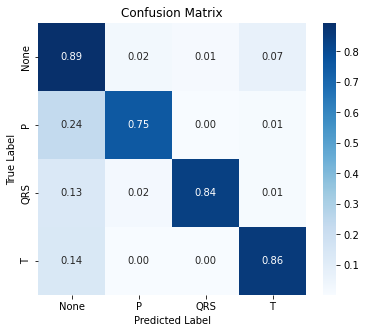

In [ ]:
pred_mask_all = []
true_mask_all = []

for batch_idx, (signals, labels) in enumerate(valid_loader):
    ecg_data, ecg_mask = signals.cuda(), labels.cuda().long()
    with torch.no_grad():
        outputs = model(ecg_data)  # (64, 1000, 4)
    # loss = criterion(outputs.view(-1, num_classes), ecg_mask.view(-1))  # (64000, 4) vs (64000,)
    # print(f"Validation Loss: {loss.item()}")
    pred_mask = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
    pred_mask_all.append(pred_mask.cpu().numpy())
    true_mask_all.append(ecg_mask.cpu().numpy())

pred_mask_all = np.vstack(pred_mask_all).reshape(-1)
true_mask_all = np.vstack(true_mask_all).reshape(-1)

print(pred_mask_all.shape, true_mask_all.shape)

# calculate confusion matrix
cm = confusion_matrix(true_mask_all, pred_mask_all)

cm_prob = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# visualizing confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_prob, annot=True, fmt=".2f", cmap="Blues", xticklabels=['None','P','QRS','T'], yticklabels=['None','P','QRS','T'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

(2500,) (2500,) (2500,)


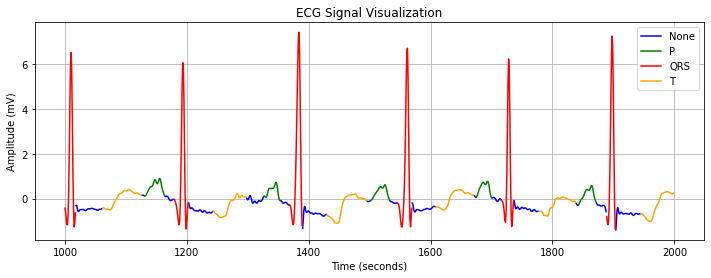

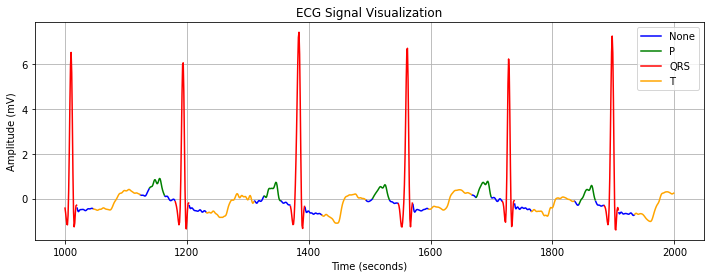

In [ ]:
# Visualize ECG Signal with Masks
# Valid set 'ecg7.mat', 'ecg72.mat', 'ecg58.mat', 'ecg168.mat', 'ecg54.mat', 'ecg93.mat', 'ecg133.mat', 'ecg110.mat', 'ecg43.mat', 'ecg36.mat', 'ecg179.mat', 'ecg102.mat', 'ecg55.mat', 'ecg42.mat', 'ecg142.mat', 'ecg97.mat', 'ecg176.mat', 'ecg156.mat', 'ecg85.mat', 'ecg182.mat', 'ecg19.mat', 'ecg82.mat', 'ecg37.mat', 'ecg124.mat', 'ecg200.mat', 'ecg203.mat', 'ecg4.mat', 'ecg1.mat', 'ecg26.mat', 'ecg202.mat', 'ecg154.mat', 'ecg139.mat', 'ecg15.mat', 'ecg71.mat', 'ecg122.mat', 'ecg2.mat', 'ecg50.mat', 'ecg131.mat', 'ecg205.mat', 'ecg204.mat', 'ecg47.mat', 'ecg111.mat', 'ecg98.mat', 'ecg31.mat', 'ecg33.mat', 'ecg208.mat', 'ecg52.mat', 'ecg65.mat', 'ecg94.mat', 'ecg115.mat', 'ecg18.mat', 'ecg27.mat', 'ecg152.mat', 'ecg207.mat', 'ecg162.mat', 'ecg167.mat', 'ecg46.mat', 'ecg39.mat', 'ecg128.mat', 'ecg32.mat', 'ecg157.mat', 'ecg91.mat', 'ecg106.mat'
start_idx = 3500
time_steps = 2500
num_of_wavelets = 40

data = sio.loadmat('./data/QTDataset_python/ecg1.mat', struct_as_record=False)
ecg_data_subject = data['ecgSignal']
ecg_label = data['signalRegionLabels']
ecg_mask_subject = change_label_to_mask(ecg_data_subject, ecg_label)

# denosing filter
ecg_data_subject = apply_bandpass_filter_butterworth(ecg_data_subject.squeeze(), 0.5, 40, 250)

# Z-Score
ecg_data_subject = zscore_norm(ecg_data_subject)

# Wavelet Transform
time = np.linspace(0, 1, ecg_data_subject.shape[0])
sampling_period = np.diff(time).mean()
widths = np.geomspace(1, 1024, num=num_of_wavelets)
cwtmatr, _ = pywt.cwt(ecg_data_subject, widths, 'cmor1.5-1.0', sampling_period=sampling_period)

x = np.array(cwtmatr[:, start_idx : start_idx + time_steps]).swapaxes(0, 1).reshape(1, time_steps, num_of_wavelets)
y = np.array(ecg_mask_subject[start_idx : start_idx + time_steps]).reshape(1, time_steps)
x = torch.from_numpy(x).to(dtype=torch.float)
y = torch.from_numpy(y).to(dtype=torch.long)

ecg_data, ecg_mask = x.cuda(), y.cuda()
with torch.no_grad():
    outputs = model(ecg_data)  # (64, 1000, 4)

pred_mask = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)

ecg_data  = ecg_data_subject[start_idx : start_idx + time_steps]
ecg_mask  = ecg_mask.cpu().numpy().squeeze()
pred_mask = pred_mask.cpu().numpy().squeeze()

print(ecg_data.shape, ecg_mask.shape, pred_mask.shape)

show_ecg_with_masks(ecg_data, ecg_mask, 250)
show_ecg_with_masks(ecg_data, pred_mask, 250)